In [6]:
import pennylane as qml
from pennylane import numpy as np
import torch
import time

In [124]:
def create_circuit(n_qubits):
    
    dev = qml.device("lightning.qubit", wires=n_qubits)
    
    @qml.qnode(dev, interface="torch")
    def circuit(params):
        
        for i in range(n_qubits):
            qml.RY(params[0, i]*np.pi, wires=i)
        for i in range(n_qubits):
            qml.IsingXX(params[1, i]*np.pi, wires=[i, (i+1)%n_qubits])
        # measurements = []
        # for i in range(n_qubits):
        #     measurements.append(qml.expval(qml.PauliZ(i)))

        return qml.expval(qml.PauliZ(0))
    
    return circuit

In [125]:
n_qubits = 5
circuit = create_circuit(n_qubits)

In [126]:
params = torch.rand((2, n_qubits), requires_grad=True)
print(params)


tensor([[0.7821, 0.9832, 0.3555, 0.9950, 0.4958],
        [0.3881, 0.6341, 0.8491, 0.5939, 0.8852]], requires_grad=True)


In [127]:
circuit(params)

tensor(0.2632, dtype=torch.float64, grad_fn=<ExecuteTapesBackward>)

/tmp/ipykernel_38295/4126486970.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


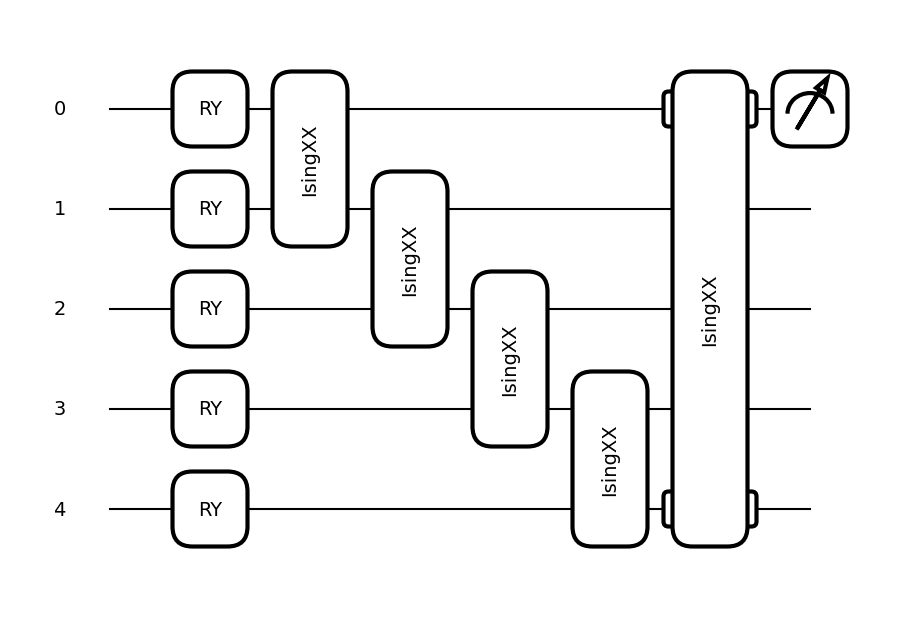

In [129]:
fig, ax = qml.draw_mpl(circuit)(params)
fig.show()

In [131]:
def cost(params):
    return (1-circuit(params))**2

In [133]:
opt = torch.optim.Adam([params], lr = 0.1)

In [143]:
steps = 200

for i in range(steps):
    
    beg = time.time()
    opt.zero_grad()
    loss = cost(params)
    loss.backward()
    opt.step()
    end = time.time()
    print("loss:", loss.item(), "\t time:", np.round((end-beg)*1000, 1), "ms")

loss: 6.188645503916933e-10 	 time: 11.4 ms
loss: 6.170325219733134e-10 	 time: 15.2 ms
loss: 6.151566863410364e-10 	 time: 14.5 ms
loss: 6.133067447708689e-10 	 time: 14.4 ms
loss: 6.115402135541092e-10 	 time: 14.6 ms
loss: 6.097736995036432e-10 	 time: 16.1 ms
loss: 6.079867326041866e-10 	 time: 15.4 ms
loss: 6.062067739069568e-10 	 time: 14.1 ms
loss: 6.04478096233324e-10 	 time: 15.0 ms
loss: 6.027060101119642e-10 	 time: 14.0 ms
loss: 6.009349527803965e-10 	 time: 10.8 ms
loss: 5.991940616511532e-10 	 time: 9.1 ms
loss: 5.97430936038716e-10 	 time: 11.3 ms
loss: 5.956974296870285e-10 	 time: 11.2 ms
loss: 5.939690791733737e-10 	 time: 11.2 ms
loss: 5.922177612486495e-10 	 time: 10.5 ms
loss: 5.90473303583159e-10 	 time: 10.0 ms
loss: 5.887552581604891e-10 	 time: 9.8 ms
loss: 5.87041503831019e-10 	 time: 14.8 ms
loss: 5.853058819779215e-10 	 time: 12.4 ms
loss: 5.835742042819816e-10 	 time: 9.6 ms
loss: 5.818729150744357e-10 	 time: 9.0 ms
loss: 5.801740513949712e-10 	 time: 9.7 

In [141]:
beg = time.time()
time.sleep(1)
end = time.time()
end-beg

1.000345230102539

## Real testing

In [167]:
steps = 200
file_name="pennylane.csv"

In [168]:
def test_time(n_qubits):
    circuit = create_circuit(n_qubits)
    params = torch.rand((2, n_qubits), requires_grad=True)
    def cost(params):
        return (1 - circuit(params))**2
    
    opt = torch.optim.Adam([params], lr = 0.1)
    beg_steps = 5
    for i in range(steps+beg_steps):
        if (i == beg_steps):
            beg = time.time()
        opt.zero_grad()
        loss = cost(params)
        loss.backward()
        opt.step()
    end = time.time()
    return (end-beg)*1000

In [173]:
from bench_func import run_benchmark

run_benchmark(range(2, 22), test_time, file_name)

  0%|          | 0/20 [00:00<?, ?it/s]

[2, 722.7649688720703]
[3, 1154.0467739105225]
[4, 1576.2629508972168]
[5, 2211.4205360412598]
[6, 2474.904775619507]
[7, 3374.466896057129]
[8, 4183.089971542358]
[9, 4995.209217071533]
[10, 6047.146320343018]
[11, 6764.789819717407]
[12, 8917.454719543457]
[13, 12870.530128479004]
[14, 15046.837091445923]
[15, 22922.544240951538]
[16, 34204.81038093567]
[17, 59179.59451675415]
[18, 106579.82730865479]
[19, 223136.61313056946]
[20, 1064649.9555110931]


KeyboardInterrupt: 

### standard simulator comparison

In [174]:
def create_circuit(n_qubits):
    
    dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev, interface="torch")
    def circuit(params):
        
        for i in range(n_qubits):
            qml.RY(params[0, i]*np.pi, wires=i)
        for i in range(n_qubits):
            qml.IsingXX(params[1, i]*np.pi, wires=[i, (i+1)%n_qubits])
        # measurements = []
        # for i in range(n_qubits):
        #     measurements.append(qml.expval(qml.PauliZ(i)))

        return qml.expval(qml.PauliZ(0))
    
    return circuit

In [175]:
steps = 200
file_name="pennylane_default.csv"

In [2]:
def test_time(n_qubits):
    circuit = create_circuit(n_qubits)
    params = torch.rand((2, n_qubits), requires_grad=True)
    def cost(params):
        return (1 - circuit(params))**2
    
    opt = torch.optim.Adam([params], lr = 0.1)
    beg_steps = 5
    for i in range(steps+beg_steps):
        if (i == beg_steps):
            beg = time.time()
        opt.zero_grad()
        loss = cost(params)
        loss.backward()
        opt.step()
    end = time.time()
    return (end-beg)*1000

In [177]:
from bench_func import run_benchmark

run_benchmark(range(2, 22), test_time, file_name)

  0%|          | 0/20 [00:00<?, ?it/s]

[2, 578.2110691070557]
[3, 795.2024936676025]
[4, 1035.4628562927246]
[5, 1295.1016426086426]
[6, 1539.4742488861084]
[7, 1986.0031604766846]
[8, 2621.9358444213867]
[9, 3195.876121520996]
[10, 3651.0398387908936]
[11, 3586.088180541992]
[12, 4023.5421657562256]
[13, 4638.354063034058]
[14, 5476.943492889404]
[15, 7176.120758056641]
[16, 9698.828220367432]
[17, 16247.95126914978]
[18, 36483.84618759155]
[19, 101134.68599319458]


qsim inside pennylane

In [1]:
def create_circuit(n_qubits):
    
    dev = qml.device("cirq.qsim", wires=n_qubits)
    
    @qml.qnode(dev, interface="torch")
    def circuit(params):
        
        for i in range(n_qubits):
            qml.RY(params[0, i]*np.pi, wires=i)
        for i in range(n_qubits):
            qml.IsingXX(params[1, i]*np.pi, wires=[i, (i+1)%n_qubits])
        # measurements = []
        # for i in range(n_qubits):
        #     measurements.append(qml.expval(qml.PauliZ(i)))

        return qml.expval(qml.PauliZ(0))
    
    return circuit

In [3]:
steps = 200
file_name="pennylane_qsim.csv"

In [8]:
from bench_func import run_benchmark

run_benchmark(range(2, 22), test_time, file_name)

  0%|          | 0/20 [00:00<?, ?it/s]

[2, 2205.5821418762207]
[3, 3928.9917945861816]
[4, 5825.104236602783]
[5, 8853.173971176147]
[6, 11978.827714920044]
[7, 15020.973443984985]
[8, 20320.2965259552]
[9, 24027.501106262207]
[10, 30977.929830551147]
[11, 35051.639556884766]
[12, 42624.927282333374]
[13, 47516.804456710815]


KeyboardInterrupt: 